In [1]:
import os
import time
import torch
import math
import torchvision
from torchvision import transforms as transforms
from torch import nn
from torch.nn import functional as F
from math import cos,pi

import matplotlib.pyplot as plt
import numpy as np
import random

torch.cuda.empty_cache()

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.manual_seed(17)
torch.cuda.manual_seed_all(17)

aug_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(), # 水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

aug_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

trainingdata = torchvision.datasets.CIFAR10('./CIFAR10',train=True,download=True,transform=aug_train)
# testdata = torchvision.datasets.CIFAR10('./CIFAR10',train=False,download=True,transform=transforms.ToTensor())
# print(len(trainingdata),len(testdata))

Files already downloaded and verified


In [4]:
def load_data(is_train,aug,batch_size):
    dataset = torchvision.datasets.CIFAR10('./CIFAR10',train=is_train,download=True,transform=aug)
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=is_train)
    return dataloader

batch_size = 128 # param
trainDataLoader = load_data(is_train=True,aug=aug_train,batch_size=batch_size)
testDataLoader = load_data(is_train=False,aug=aug_test,batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32]) 6


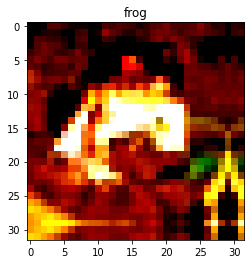

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

image,label = trainingdata[0]
print(image.shape, label)

%matplotlib inline
plt.imshow(image.numpy().transpose(1,2,0))
plt.title(str(classes[label]))
plt.show()

In [6]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
#         print(x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
#         print(out.shape)
        out = self.layer1(out)
#         print(out.shape)
        out = self.layer2(out)
#         print(out.shape)
        out = self.layer3(out)
#         print(out.shape)
#         out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
#         print(out.shape)
        out = out.view(out.size(0), -1)
#         print(out.shape)
        out = self.linear(out)
        return out
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu') # weight initialization
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,std=1e-3)
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)

def project1_model():
#     return ResNet(BasicBlock, [2, 2, 2, 2])
    return ResNet(BasicBlock, [3, 3, 3])

# model1 = nn.Sequential(project1_model(), nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 10)).cuda()
model1 = project1_model().cuda()
model1.init_weights()

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(model1))

4335434


In [8]:
# X = torch.rand(size=(1, 3, 32, 32)).cuda()
# for layer in model1:
#   X = layer(X)
#   print(layer.__class__.__name__,'output shape:\t', X.shape)

In [9]:
def adjust_learning_rate(optimizer, current_epoch,max_epoch,lr_min=0,lr_max=0.1,warmup=True):
    warmup_epoch = 10 if warmup else 0
    if current_epoch < warmup_epoch:
        lr = lr_max * current_epoch / warmup_epoch
    else:
        lr = lr_min + (lr_max-lr_min)*(1 + cos(pi * (current_epoch - warmup_epoch) / (max_epoch - warmup_epoch))) / 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [10]:
num_epochs = 1000 # param
epoch_start = 0
path = 'resnet_aug_3block_sgd_warmup_consine_batch128_lr01_epoch1000.pt'

train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

Loss = torch.nn.CrossEntropyLoss()

lr = 0.1
lr_min=0.001
momentum = 0.9
nesterov = True
optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=momentum,nesterov=nesterov)



if os.path.exists(path):
    checkpoint = torch.load(path)
    print('Read model from checkpoint')
    model1.cuda().load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_start = checkpoint['epoch']
    Loss = checkpoint['Loss']
    train_loss_history = checkpoint['train_loss_history']
    test_loss_history = checkpoint['test_loss_history']
    train_accuracy_history = checkpoint['train_accuracy_history']
    test_accuracy_history = checkpoint['test_accuracy_history']
    print('Restart from epoch',epoch_start)
    

for epoch in range(epoch_start+1, num_epochs+1):
    timestart = time.time()

    train_loss = 0.0
    test_loss = 0.0
    train_accuracy = 0.0
    test_accuracy = 0.0

    for i, data in enumerate(trainDataLoader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        predicted_output = model1.cuda()(images)
        fit = Loss(predicted_output,labels)
        fit.backward()
        adjust_learning_rate(optimizer=optimizer,current_epoch=epoch,max_epoch=num_epochs,lr_min=lr_min,lr_max=lr,warmup=True)
        optimizer.step()
        train_loss += fit.item()
        train_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()

    for i, data in enumerate(testDataLoader):
        with torch.no_grad():
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            predicted_output = model1.cuda()(images)
            fit = Loss(predicted_output,labels)
            test_loss += fit.item()
            test_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()


    train_loss = train_loss/len(trainDataLoader)
    test_loss = test_loss/len(testDataLoader)
    train_accu = train_accuracy/len(trainDataLoader)
    test_accu = test_accuracy/len(testDataLoader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accu)
    test_accuracy_history.append(test_accu)
    print('Epoch %s, Train loss %s, Test loss %s, Train accuracy %s, Test accuracy %s, Cost %s s'%(epoch,
                                                                                                   train_loss,test_loss,
                                                                                                   train_accu,test_accu,
                                                                                                   time.time()-timestart))

    if epoch % 5 == 0 and epoch != 0:
        torch.save({'epoch':epoch,
          'model_state_dict':model1.cuda().state_dict(),
          'optimizer_state_dict':optimizer.state_dict(),
          'Loss':Loss,
          'train_loss_history':train_loss_history,
          'test_loss_history':test_loss_history,
          'train_accuracy_history':train_accuracy_history,
          'test_accuracy_history':test_accuracy_history},path)
        print('Model saved in epoch %s'%(epoch))

Read model from checkpoint
Restart from epoch 740
Epoch 741, Train loss 6.846498047846465e-06, Test loss 0.4590791494031496, Train accuracy 100.0, Test accuracy 94.42246835443038, Cost 55.03305172920227 s
Epoch 742, Train loss 4.510278560843953e-06, Test loss 0.4590218788649462, Train accuracy 100.0, Test accuracy 94.42246835443038, Cost 54.67599701881409 s
Epoch 743, Train loss 6.91469443867588e-06, Test loss 0.4589419368701645, Train accuracy 100.0, Test accuracy 94.42246835443038, Cost 54.63404440879822 s
Epoch 744, Train loss 7.583963495012086e-06, Test loss 0.45872905770245986, Train accuracy 100.0, Test accuracy 94.41257911392405, Cost 54.76042151451111 s
Epoch 745, Train loss 5.880551619723494e-06, Test loss 0.45874493451246734, Train accuracy 100.0, Test accuracy 94.40268987341773, Cost 54.656633377075195 s
Model saved in epoch 745
Epoch 746, Train loss 4.838701979977745e-06, Test loss 0.4587302570573137, Train accuracy 100.0, Test accuracy 94.41257911392405, Cost 54.7171754837

Epoch 792, Train loss 4.123862387515996e-06, Test loss 0.46020615737460835, Train accuracy 100.0, Test accuracy 94.40268987341773, Cost 54.58200287818909 s
Epoch 793, Train loss 4.361661952049055e-06, Test loss 0.46023750479651404, Train accuracy 100.0, Test accuracy 94.40268987341773, Cost 54.578553199768066 s
Epoch 794, Train loss 6.010719840027198e-06, Test loss 0.4602170498876632, Train accuracy 100.0, Test accuracy 94.41257911392405, Cost 54.587109088897705 s
Epoch 795, Train loss 4.143476806629063e-06, Test loss 0.4602307457052454, Train accuracy 100.0, Test accuracy 94.41257911392405, Cost 54.55879092216492 s
Model saved in epoch 795
Epoch 796, Train loss 2.8318782573795374e-06, Test loss 0.4602227745271182, Train accuracy 100.0, Test accuracy 94.41257911392405, Cost 54.561481952667236 s
Epoch 797, Train loss 4.524793503117358e-06, Test loss 0.46026465273167516, Train accuracy 100.0, Test accuracy 94.41257911392405, Cost 54.56685996055603 s
Epoch 798, Train loss 3.57255196819535

Epoch 844, Train loss 3.4105725065358665e-06, Test loss 0.46056834080174, Train accuracy 100.0, Test accuracy 94.44224683544304, Cost 54.453327894210815 s
Epoch 845, Train loss 6.134611716390453e-06, Test loss 0.46052304617589035, Train accuracy 100.0, Test accuracy 94.4323575949367, Cost 54.45641207695007 s
Model saved in epoch 845
Epoch 846, Train loss 4.93502889709404e-06, Test loss 0.460517428249498, Train accuracy 100.0, Test accuracy 94.44224683544304, Cost 54.44863438606262 s
Epoch 847, Train loss 4.616204761239277e-06, Test loss 0.4605348346919953, Train accuracy 100.0, Test accuracy 94.4323575949367, Cost 54.53994941711426 s
Epoch 848, Train loss 5.3664339188742324e-06, Test loss 0.4605324986520447, Train accuracy 100.0, Test accuracy 94.4323575949367, Cost 54.58146119117737 s
Epoch 849, Train loss 4.104141463597955e-06, Test loss 0.4605342576492436, Train accuracy 100.0, Test accuracy 94.4323575949367, Cost 54.5881667137146 s
Epoch 850, Train loss 4.409008948249406e-06, Test 

Epoch 896, Train loss 3.4652579985557624e-06, Test loss 0.4607576403908337, Train accuracy 100.0, Test accuracy 94.42246835443038, Cost 54.486493825912476 s
Epoch 897, Train loss 5.688612169740303e-06, Test loss 0.4607687666540659, Train accuracy 100.0, Test accuracy 94.4323575949367, Cost 54.46090650558472 s
Epoch 898, Train loss 4.703708308510641e-06, Test loss 0.46076073506964915, Train accuracy 100.0, Test accuracy 94.4323575949367, Cost 54.432944536209106 s
Epoch 899, Train loss 4.155918789176457e-06, Test loss 0.46077343430134315, Train accuracy 100.0, Test accuracy 94.4323575949367, Cost 54.41728758811951 s
Epoch 900, Train loss 4.077100187319822e-06, Test loss 0.4607725675347485, Train accuracy 100.0, Test accuracy 94.4323575949367, Cost 54.421642541885376 s
Model saved in epoch 900
Epoch 901, Train loss 3.739570931045169e-06, Test loss 0.46077919675956797, Train accuracy 100.0, Test accuracy 94.4323575949367, Cost 54.468762159347534 s
Epoch 902, Train loss 3.997334827867308e-0

Epoch 948, Train loss 5.191822998703018e-06, Test loss 0.46085587577729287, Train accuracy 100.0, Test accuracy 94.42246835443038, Cost 54.71532082557678 s
Epoch 949, Train loss 5.198716775899737e-06, Test loss 0.46085847268187546, Train accuracy 100.0, Test accuracy 94.42246835443038, Cost 54.7364764213562 s
Epoch 950, Train loss 4.466121757376489e-06, Test loss 0.4608623525952991, Train accuracy 100.0, Test accuracy 94.4323575949367, Cost 54.703755378723145 s
Model saved in epoch 950
Epoch 951, Train loss 4.293588289343411e-06, Test loss 0.46086762737058384, Train accuracy 100.0, Test accuracy 94.42246835443038, Cost 54.62871217727661 s
Epoch 952, Train loss 4.257450346295473e-06, Test loss 0.4608694650232792, Train accuracy 100.0, Test accuracy 94.42246835443038, Cost 54.64526414871216 s
Epoch 953, Train loss 4.679464592350711e-06, Test loss 0.46087369695305824, Train accuracy 100.0, Test accuracy 94.4323575949367, Cost 54.70604085922241 s
Epoch 954, Train loss 3.282012967112625e-06

Epoch 1000, Train loss 5.57242754505251e-06, Test loss 0.46085569493566886, Train accuracy 100.0, Test accuracy 94.4323575949367, Cost 54.43100690841675 s
Model saved in epoch 1000


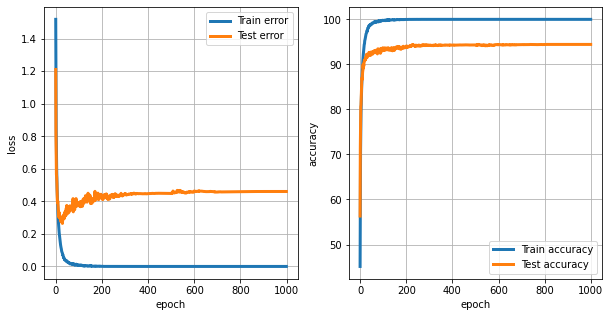

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(num_epochs),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(num_epochs),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(num_epochs),train_accuracy_history,'-',linewidth=3,label='Train accuracy')
plt.plot(range(num_epochs),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

In [12]:
print('Accuracy:',sum(test_accuracy_history[-5:])/5)

Accuracy: 94.4323575949367


In [ ]:
num_epochs = 500 # param
epoch_start = 0
path = 'resnet_aug_3block_sgd_warmup_consine_batch128_lr01_epoch1000.pt'

train_error = []
test_error = []

checkpoint = torch.load(path)
print('Read model from checkpoint')
train_loss_history = checkpoint['train_loss_history']
test_loss_history = checkpoint['test_loss_history']
train_accuracy_history = checkpoint['train_accuracy_history']
test_accuracy_history = checkpoint['test_accuracy_history']

for i in range(num_epochs):
    train_error.append(100-train_accuracy_history[i])
    test_error.append(100-test_accuracy_history[i])
    
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(num_epochs),train_loss_history[0:num_epochs],'-',linewidth=3,label='Train loss')
plt.plot(range(num_epochs),test_loss_history[0:num_epochs],'-',linewidth=3,label='Test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(num_epochs),train_error,'-',linewidth=3,label='Train error')
plt.plot(range(num_epochs),test_error,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('error')
plt.grid(True)
plt.legend()

Read model from checkpoint
